# Anomaly detection

In [41]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import joblib
import matplotlib.pyplot as plt

### Load and visualize batch

X shape: torch.Size([50, 300, 8])
y shape: torch.Size([50, 300, 8])

Lat/Lon stats (X):
  lat min/max: -1.016595482826233 1.8581050634384155
  lon min/max: -2.6247265338897705 1.6638569831848145


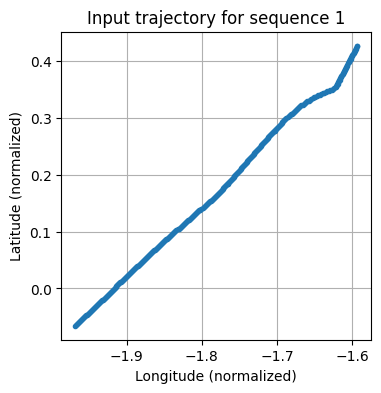

In [38]:
# Load the batch
batch = torch.load("sample_batch.pt")
X = batch["X"]  # shape: [B, T, F]
y = batch["y"]  # shape: [B, T, F]

print("X shape:", X.shape)
print("y shape:", y.shape)

# Assume feature 0 = Latitude, 1 = Longitude (adjust if needed)
lat_idx, lon_idx = 0, 1

# 2) Quick sanity stats
print("\nLat/Lon stats (X):")
print("  lat min/max:", X[:, :, lat_idx].min().item(), X[:, :, lat_idx].max().item())
print("  lon min/max:", X[:, :, lon_idx].min().item(), X[:, :, lon_idx].max().item())

# 3) Plot one example trajectory (input X[0])
seq_id = 1
seq = X[seq_id].cpu()

plt.figure(figsize=(4, 4))
plt.plot(seq[:, lon_idx], seq[:, lat_idx], marker=".", linestyle="-", linewidth=1)
plt.xlabel("Longitude (normalized)")
plt.ylabel("Latitude (normalized)")
plt.title(f"Input trajectory for sequence {seq_id}")
plt.grid(True)
plt.show()

In [111]:
from lstm_model import LSTMModel
input_size_base = 2
input_size_8 = 8 
hidden_size = 128
num_layers = 3 
output_size_base = 2
output_size_8 = 8 
dropout = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_base = LSTMModel(input_size_base, hidden_size, num_layers, output_size_base, dropout).to(device)
model_8 = LSTMModel(input_size_8, hidden_size, num_layers, output_size_8, dropout).to(device)

FEATURES_BASE = [
    'Latitude', 'Longitude']
FEATURES_8 = [
    'Latitude', 'Longitude', 'SOG', 'COG', 'Latitude_known', 'Longitude_known', 'SOG_known', 'COG_known'

]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [112]:
def rolling_forecast_lstm_batch_with_mask(model, batch_X, steps=300, device=device, FEATURES=FEATURES_BASE):
    model.eval()
    batch_X = batch_X.to(device)
    preds = []

    # global FEATURES has length 8, but the model output might not
    with torch.no_grad():
        input_seq = batch_X.clone()
        for _ in range(steps):
            out = model(input_seq)          # (B, seq_len, F)
            next_point = out[:, -1, :]      # (B, F)
            num_features = next_point.shape[-1]

            # only keep known-flag indices that are < num_features
            known_idx = [
                i for i, f in enumerate(FEATURES)
                if f.endswith("_known") and i < num_features
            ]
            if known_idx:
                next_point[:, known_idx] = 0.0

            preds.append(next_point.cpu().numpy())
            next_point_expanded = next_point.unsqueeze(1)  # (B,1,F)
            input_seq = torch.cat(
                [input_seq[:, 1:, :], next_point_expanded], dim=1
            )
    return np.stack(preds, axis=1)  # (B, steps, F)

## Basemodel: Lat  / long

In [115]:
scaler = joblib.load("scaler_with_mask.joblib")
state_dict = torch.load("models/best_lstm_model_Latitude_Longitude.pth", map_location=device)
model_base.load_state_dict(state_dict)
model_base.eval()

batch = torch.load("sample_batch.pt")
X_full = batch["X"]   # (B, T, 8)
y_full = batch["y"]   # (B, T, 8)

lat_idx, lon_idx = 0, 1  # adjust if needed

X = X_full[:, :, [lat_idx, lon_idx]]   # (B, T, 2)
y = y_full[:, :, [lat_idx, lon_idx]]   # (B, T, 2)

device = next(model_base.parameters()).device



# Stack predictions to get final array: (B, steps, model_output_features)
y_pred_full = rolling_forecast_lstm_batch_with_mask(model_base, X, steps=300, device=device, FEATURES=FEATURES_BASE)

robust_scaler = scaler[0]
feature_list  = scaler[1]

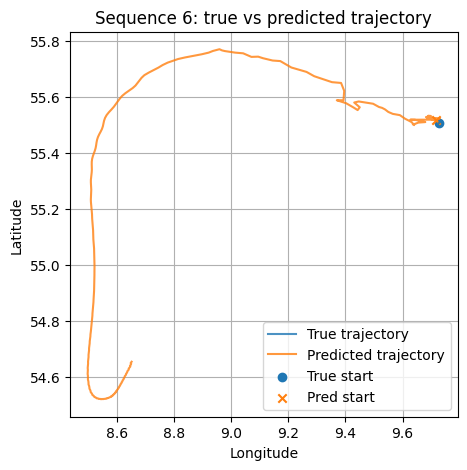

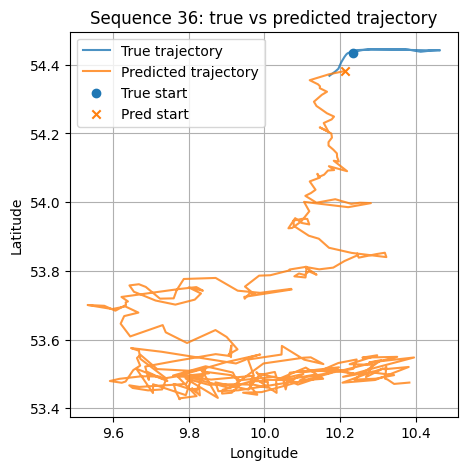

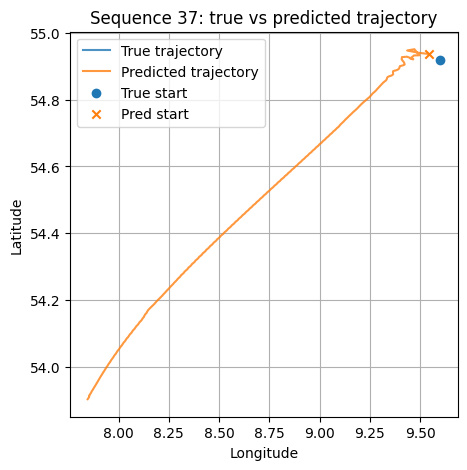

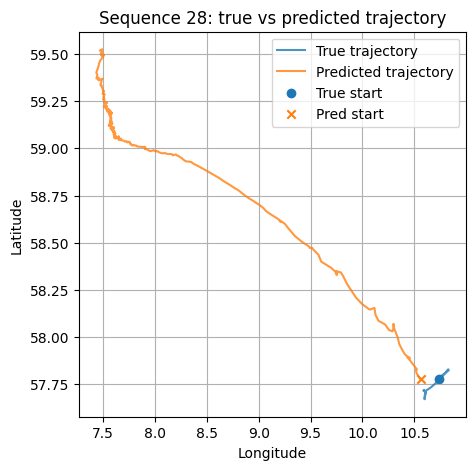

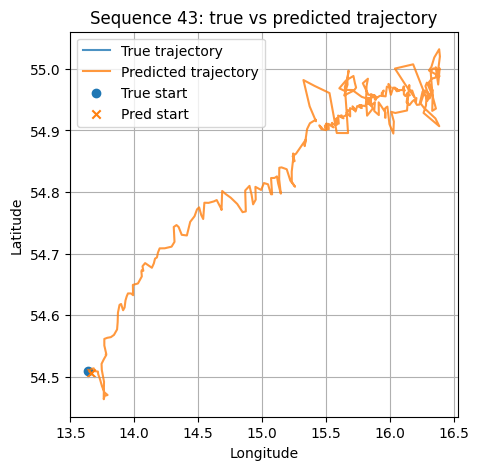

In [120]:
lat_idx, lon_idx = 0, 1
scaled_idx = [0, 1, 2, 3]   # Latitude, Longitude, SOG, COG

np.random.seed(100)
example_ids = np.random.choice(50, size=5, replace=False)
example_ids = example_ids.tolist()

for i in example_ids:
    y_true_seq_scaled = y_full[i]       # (T, 8)
    y_pred_seq_scaled = np.hstack([y_pred_full[i], y_pred_full[i]])  # (T, 8)

    y_true_unscaled = robust_scaler.inverse_transform(y_true_seq_scaled[:, :4])

    y_pred_unscaled = robust_scaler.inverse_transform(y_pred_seq_scaled[:, :4])

    true_lat = y_true_unscaled[:, lat_idx]
    true_lon = y_true_unscaled[:, lon_idx]
    pred_lat = y_pred_unscaled[:, lat_idx]
    pred_lon = y_pred_unscaled[:, lon_idx]

    plt.figure(figsize=(5, 5))
    plt.plot(true_lon, true_lat, label="True trajectory", alpha=0.8)
    plt.plot(pred_lon, pred_lat, label="Predicted trajectory", alpha=0.8)

    plt.scatter(true_lon[0], true_lat[0], marker="o", label="True start")
    plt.scatter(pred_lon[0], pred_lat[0], marker="x", label="Pred start")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Sequence {i}: true vs predicted trajectory")
    plt.legend()
    plt.grid(True)
    plt.show()


## 8-feature Model

In [118]:
scaler = joblib.load("scaler_with_mask.joblib")
state_dict = torch.load("models/best_lstm_model_Latitude_Longitude_SOG_COG_SOG_known_COG_known_Latitude_known_Longitude_known.pth", map_location=device)
model_8.load_state_dict(state_dict)
model_8.eval()

batch = torch.load("sample_batch.pt")
X_full = batch["X"]   # (B, T, 8)
y_full = batch["y"]   # (B, T, 8)

lat_idx, lon_idx = 0, 1  # adjust if needed

X = X_full.clone()  # (B, T, 2)
y = y_full.clone()  # (B, T, 2)

device = next(model_8 .parameters()).device

# Get predictions from 8-feature model
y_pred_full = rolling_forecast_lstm_batch_with_mask(model_8, X, steps=300, device=device, FEATURES=FEATURES_8)

robust_scaler = scaler[0]   # this is the actual RobustScaler
feature_list  = scaler[1]   # probably ["Latitude", "Longitude", ...]

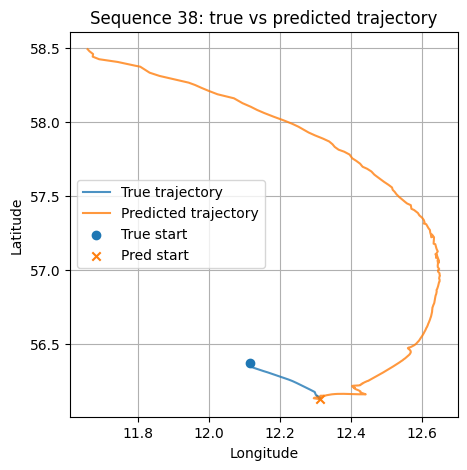

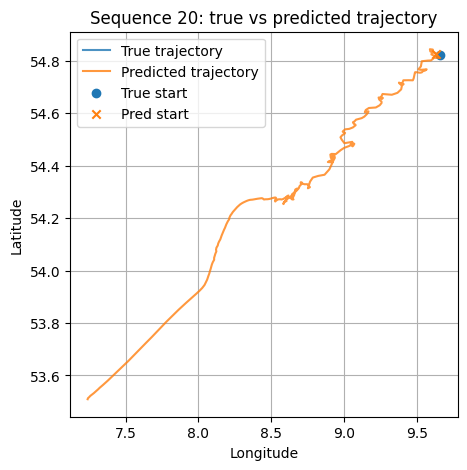

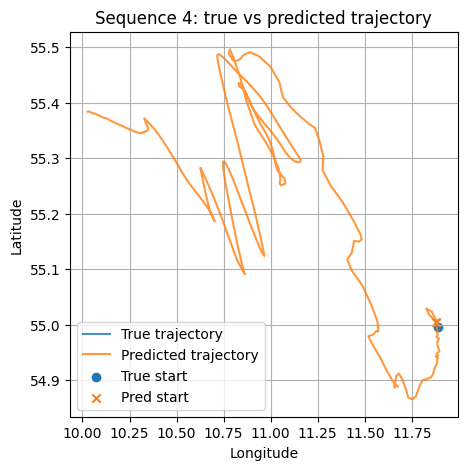

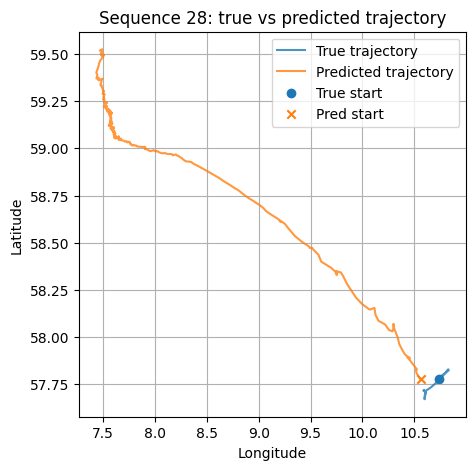

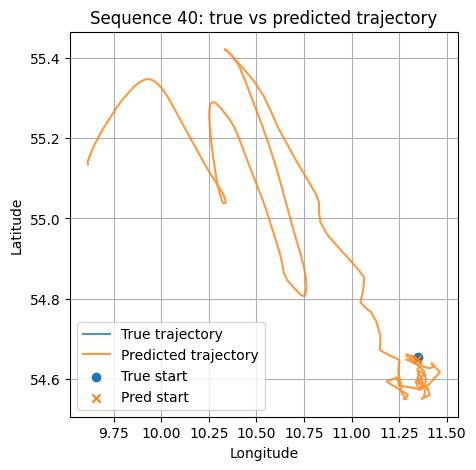

In [119]:
lat_idx, lon_idx = 0, 1
scaled_idx = [0, 1, 2, 3]   # Latitude, Longitude, SOG, COG

np.random.seed(60)
example_ids = np.random.choice(50, size=5, replace=False)
example_ids = example_ids.tolist()

for i in example_ids:
    y_true_seq_scaled = y_full[i]       # (T, 8)
    y_pred_seq_scaled = np.hstack([y_pred_full[i], y_pred_full[i]])  # (T, 8)

    y_true_unscaled = robust_scaler.inverse_transform(y_true_seq_scaled[:, :4])

    y_pred_unscaled = robust_scaler.inverse_transform(y_pred_seq_scaled[:, :4])

    true_lat = y_true_unscaled[:, lat_idx]
    true_lon = y_true_unscaled[:, lon_idx]
    pred_lat = y_pred_unscaled[:, lat_idx]
    pred_lon = y_pred_unscaled[:, lon_idx]

    plt.figure(figsize=(5, 5))
    plt.plot(true_lon, true_lat, label="True trajectory", alpha=0.8)
    plt.plot(pred_lon, pred_lat, label="Predicted trajectory", alpha=0.8)

    plt.scatter(true_lon[0], true_lat[0], marker="o", label="True start")
    plt.scatter(pred_lon[0], pred_lat[0], marker="x", label="Pred start")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Sequence {i}: true vs predicted trajectory")
    plt.legend()
    plt.grid(True)
    plt.show()


## Results of base model (2 features)

Threshold file keys: ['mse_lat_thr', 'mse_lon_thr', 'mean_lat', 'mean_lon', 'std_lat', 'std_lon', 'K_SIGMA', 'STEPS']
K_SIGMA: 3.0 STEPS: 30
Rows: 383970
Unique (batch, sample): 12799
Overall anomaly rate (any coord, any step): 0.014795426726046305


step_ahead
1     0.002344
2     0.012814
3     0.002813
4     0.014454
5     0.008126
6     0.003282
7     0.000703
8     0.001406
9     0.004610
10    0.007657
11    0.010470
12    0.009688
13    0.005469
14    0.018595
15    0.019923
16    0.007110
17    0.007110
18    0.006172
19    0.024533
20    0.024924
21    0.025783
22    0.026252
23    0.027033
24    0.027424
25    0.027658
26    0.028127
27    0.028127
28    0.026799
29    0.023517
30    0.010938
Name: anom_any, dtype: float64

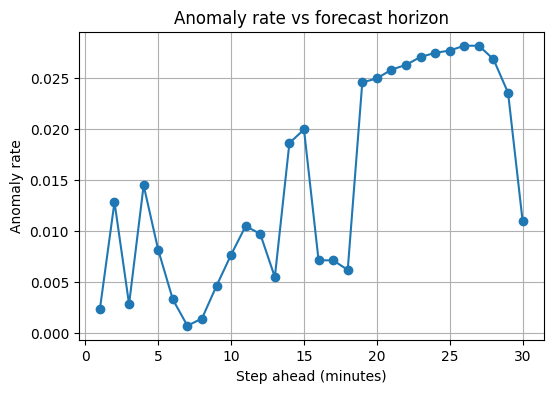

In [66]:
PROJECT_ROOT = Path.cwd()  # or set explicitly if needed
RES_DIR = PROJECT_ROOT

thr_path = RES_DIR / "model_results_base/anomaly/thresholds_base.npz"
parquet_path = RES_DIR / "model_results_base/anomaly/anomalies_steps_30.parquet"

# Load thresholds
thr = np.load(thr_path)
print("Threshold file keys:", thr.files)

mse_lat_thr = thr["mse_lat_thr"]
mse_lon_thr = thr["mse_lon_thr"]
mean_lat = thr["mean_lat"]
mean_lon = thr["mean_lon"]
std_lat = thr["std_lat"]
std_lon = thr["std_lon"]
K_SIGMA = float(thr["K_SIGMA"])
STEPS = int(thr["STEPS"])

print("K_SIGMA:", K_SIGMA, "STEPS:", STEPS)

# Load anomaly table
df = pd.read_parquet(parquet_path)
print("Rows:", len(df))
print("Unique (batch, sample):", df[["batch_idx", "sample_idx"]].drop_duplicates().shape[0])

print("Overall anomaly rate (any coord, any step):", df["anom_any"].mean())

# per-step anomaly rates
step_stats = df.groupby("step_ahead")["anom_any"].mean()
display(step_stats)

plt.figure(figsize=(6,4))
step_stats.plot(marker="o")
plt.xlabel("Step ahead (minutes)")
plt.ylabel("Anomaly rate")
plt.title("Anomaly rate vs forecast horizon")
plt.grid(True)
plt.show()


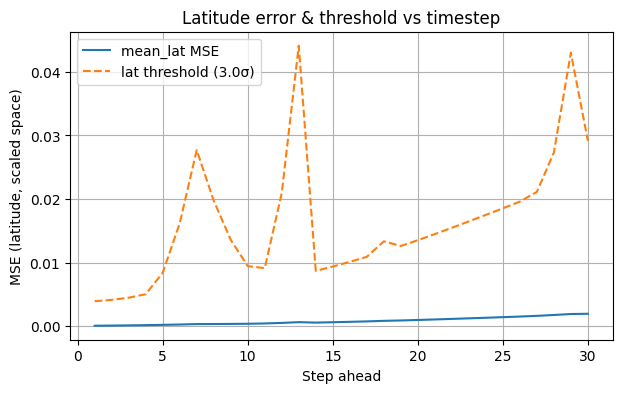

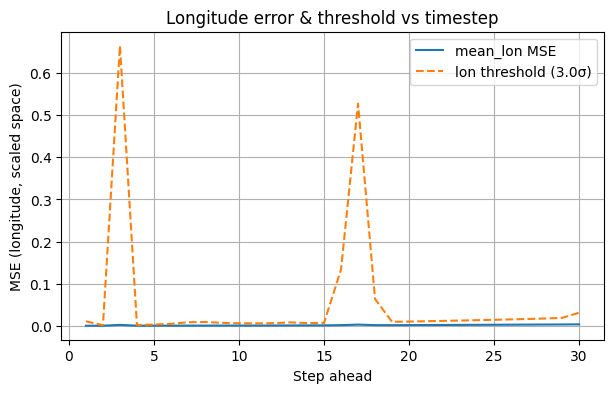

In [67]:
steps = np.arange(1, STEPS+1)

plt.figure(figsize=(7,4))
plt.plot(steps, mean_lat, label="mean_lat MSE")
plt.plot(steps, mean_lat + K_SIGMA*std_lat, linestyle="--", label=f"lat threshold ({K_SIGMA}σ)")
plt.xlabel("Step ahead")
plt.ylabel("MSE (latitude, scaled space)")
plt.title("Latitude error & threshold vs timestep")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(steps, mean_lon, label="mean_lon MSE")
plt.plot(steps, mean_lon + K_SIGMA*std_lon, linestyle="--", label=f"lon threshold ({K_SIGMA}σ)")
plt.xlabel("Step ahead")
plt.ylabel("MSE (longitude, scaled space)")
plt.title("Longitude error & threshold vs timestep")
plt.legend()
plt.grid(True)
plt.show()


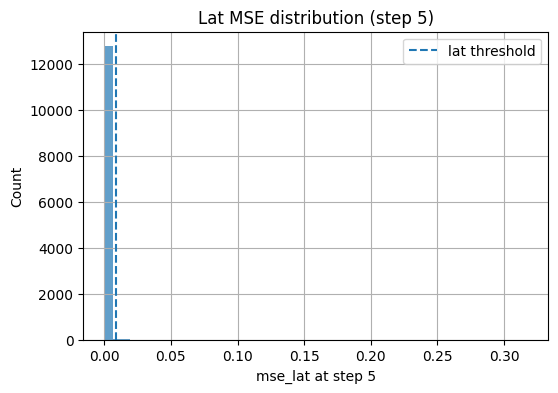

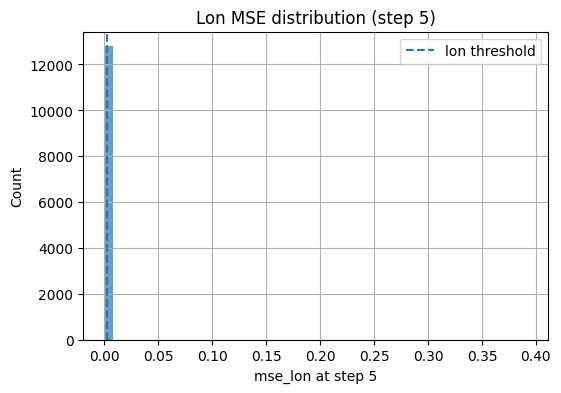

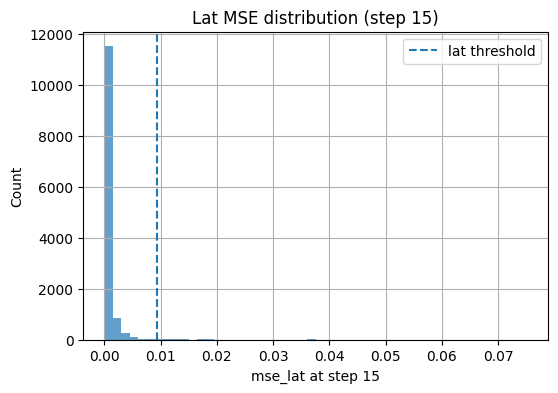

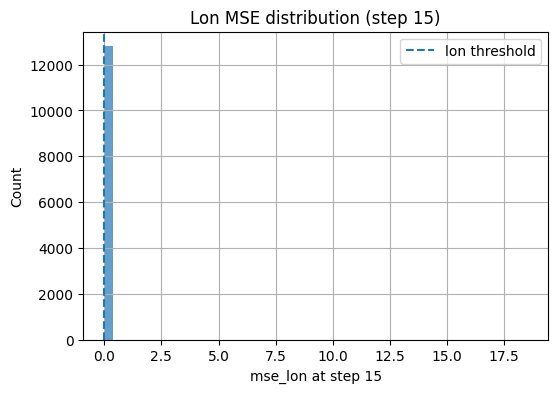

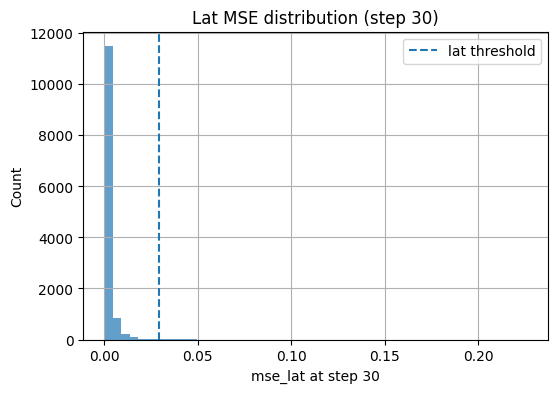

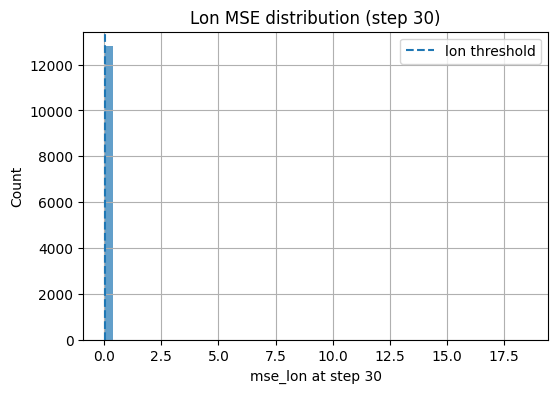

In [18]:
timesteps_to_check = [5, 15, 30]

for t in timesteps_to_check:
    subset = df[df["step_ahead"] == t]

    plt.figure(figsize=(6,4))
    subset["mse_lat"].hist(bins=50, alpha=0.7)
    plt.axvline(mse_lat_thr[t-1], linestyle="--", label="lat threshold")
    plt.xlabel(f"mse_lat at step {t}")
    plt.ylabel("Count")
    plt.title(f"Lat MSE distribution (step {t})")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    subset["mse_lon"].hist(bins=50, alpha=0.7)
    plt.axvline(mse_lon_thr[t-1], linestyle="--", label="lon threshold")
    plt.xlabel(f"mse_lon at step {t}")
    plt.ylabel("Count")
    plt.title(f"Lon MSE distribution (step {t})")
    plt.legend()
    plt.show()


## Results of advanced model (8 features)

Threshold file keys: ['mse_lat_thr', 'mse_lon_thr', 'mean_lat', 'mean_lon', 'std_lat', 'std_lon', 'K_SIGMA', 'STEPS']
K_SIGMA: 3.0 STEPS: 30
Rows: 383970
Unique (batch, sample): 12799
Overall anomaly rate (any coord, any step): 0.019019715081907442


step_ahead
1     0.021486
2     0.046566
3     0.017579
4     0.016564
5     0.014220
6     0.008516
7     0.004922
8     0.010938
9     0.017423
10    0.020861
11    0.021877
12    0.021799
13    0.019064
14    0.020080
15    0.018283
16    0.016798
17    0.016720
18    0.017814
19    0.018517
20    0.018361
21    0.019220
22    0.019611
23    0.018830
24    0.019142
25    0.019611
26    0.019611
27    0.021017
28    0.021877
29    0.021174
30    0.022111
Name: anom_any, dtype: float64

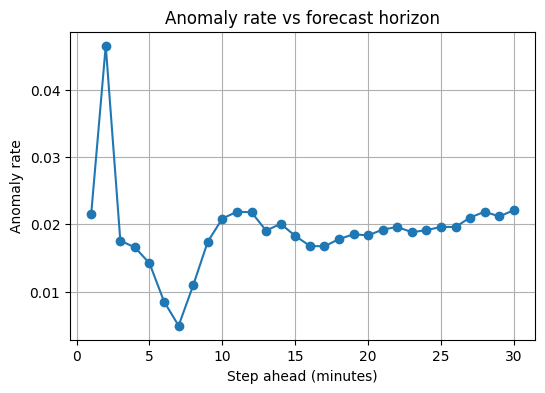

In [21]:
thr_path = RES_DIR / "model_results_8features/anomaly/thresholds_8features.npz"
parquet_path = RES_DIR / "model_results_8features/anomaly/anomalies_steps_30.parquet"

# Load thresholds
thr = np.load(thr_path)
print("Threshold file keys:", thr.files)

mse_lat_thr = thr["mse_lat_thr"]
mse_lon_thr = thr["mse_lon_thr"]
mean_lat = thr["mean_lat"]
mean_lon = thr["mean_lon"]
std_lat = thr["std_lat"]
std_lon = thr["std_lon"]
K_SIGMA = float(thr["K_SIGMA"])
STEPS = int(thr["STEPS"])

print("K_SIGMA:", K_SIGMA, "STEPS:", STEPS)

# Load anomaly table
df = pd.read_parquet(parquet_path)
print("Rows:", len(df))
print("Unique (batch, sample):", df[["batch_idx", "sample_idx"]].drop_duplicates().shape[0])

print("Overall anomaly rate (any coord, any step):", df["anom_any"].mean())

# per-step anomaly rates
step_stats = df.groupby("step_ahead")["anom_any"].mean()
display(step_stats)

plt.figure(figsize=(6,4))
step_stats.plot(marker="o")
plt.xlabel("Step ahead (minutes)")
plt.ylabel("Anomaly rate")
plt.title("Anomaly rate vs forecast horizon")
plt.grid(True)
plt.show()


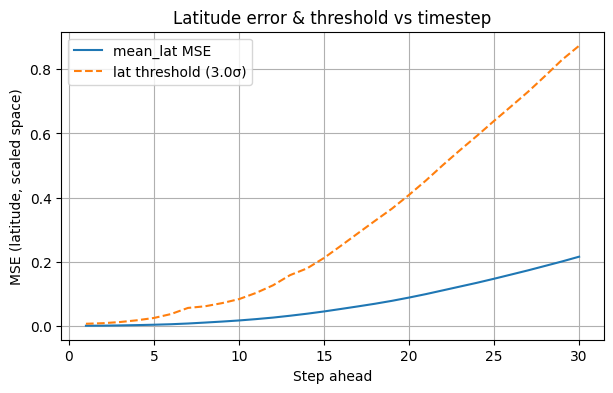

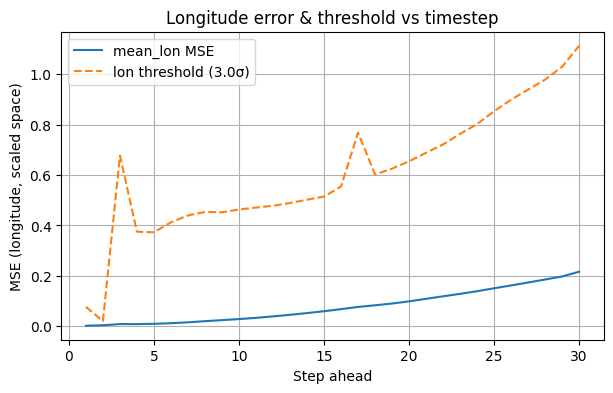

In [22]:
steps = np.arange(1, STEPS+1)

plt.figure(figsize=(7,4))
plt.plot(steps, mean_lat, label="mean_lat MSE")
plt.plot(steps, mean_lat + K_SIGMA*std_lat, linestyle="--", label=f"lat threshold ({K_SIGMA}σ)")
plt.xlabel("Step ahead")
plt.ylabel("MSE (latitude, scaled space)")
plt.title("Latitude error & threshold vs timestep")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(steps, mean_lon, label="mean_lon MSE")
plt.plot(steps, mean_lon + K_SIGMA*std_lon, linestyle="--", label=f"lon threshold ({K_SIGMA}σ)")
plt.xlabel("Step ahead")
plt.ylabel("MSE (longitude, scaled space)")
plt.title("Longitude error & threshold vs timestep")
plt.legend()
plt.grid(True)
plt.show()


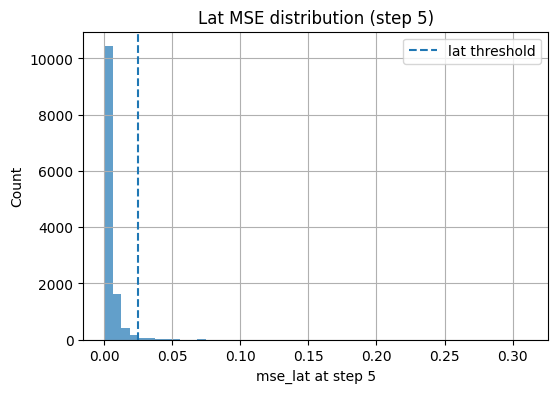

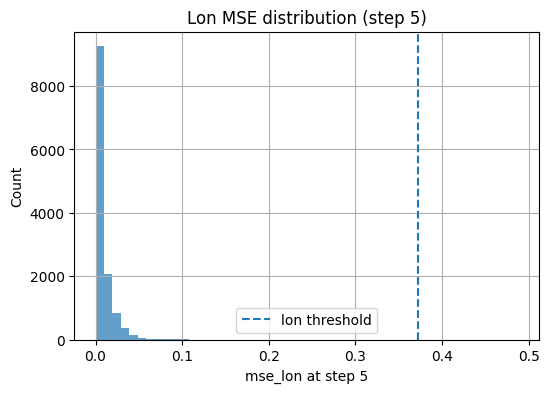

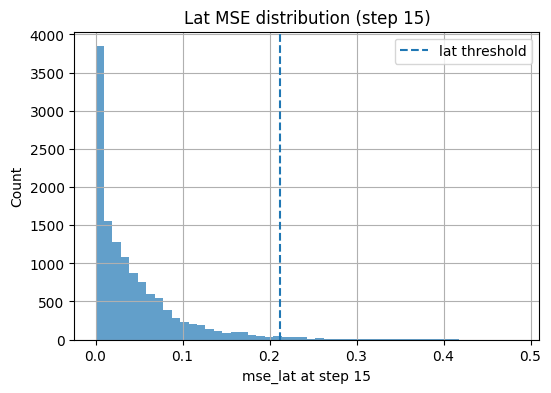

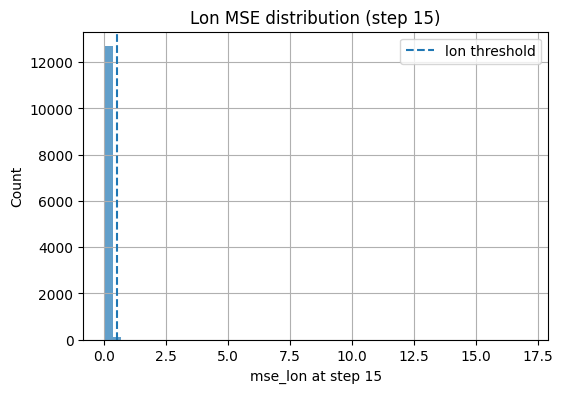

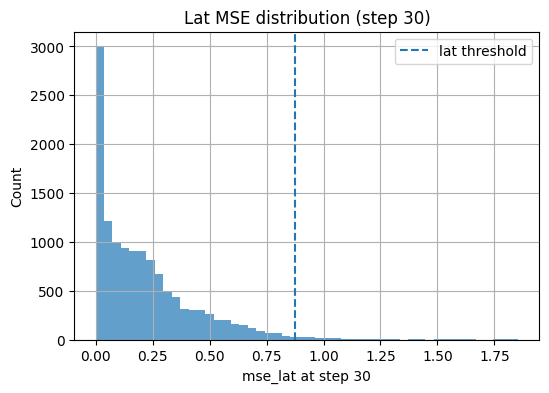

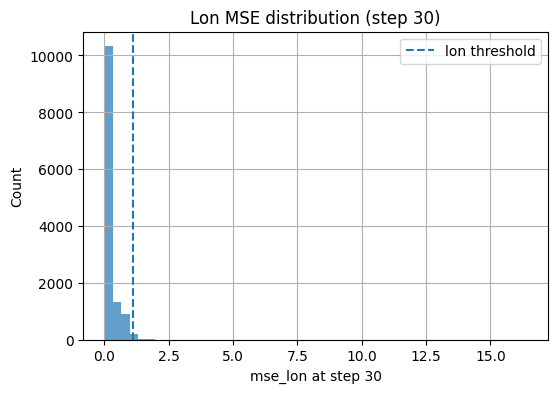

In [23]:
timesteps_to_check = [5, 15, 30]

for t in timesteps_to_check:
    subset = df[df["step_ahead"] == t]

    plt.figure(figsize=(6,4))
    subset["mse_lat"].hist(bins=50, alpha=0.7)
    plt.axvline(mse_lat_thr[t-1], linestyle="--", label="lat threshold")
    plt.xlabel(f"mse_lat at step {t}")
    plt.ylabel("Count")
    plt.title(f"Lat MSE distribution (step {t})")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    subset["mse_lon"].hist(bins=50, alpha=0.7)
    plt.axvline(mse_lon_thr[t-1], linestyle="--", label="lon threshold")
    plt.xlabel(f"mse_lon at step {t}")
    plt.ylabel("Count")
    plt.title(f"Lon MSE distribution (step {t})")
    plt.legend()
    plt.show()
